In [ ]:
# This file is currently outside the notebooks folder
%load_ext autoreload
%autoreload 2
import importlib.util
from pathlib import Path

import matplotlib.pyplot as plt
import rasterio
import torch
from rasterio.plot import show
from torchgeo.datasets import NAIP

from data.kc import KaneCounty

# from data.dem import KaneDEM
from data.sampler import BalancedRandomBatchGeoSampler

config = importlib.import_module("configs.config")
MODEL_DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [2]:
# creating a preprocessor to convert the NAIP data to float
# and normalize
def preprocess(sample):
    """Converts image data to float

    Args:
        sample: a piece of a raster image
    Returns:
        sample image data in float
    """
    if "image" in sample:
        sample["image"] = sample["image"].float() / 255.0
        return sample
    sample["mask"] = sample["mask"].float() / 255.0
    return sample

In [3]:
# creaating and combining naip and kc shape data
naip = NAIP(config.KC_IMAGE_ROOT, transforms=preprocess)
print(naip.crs)
shape_path = str(Path(config.KC_SHAPE_ROOT) / Path(config.KC_SHAPE_FILENAME))
dataset_config = (
    config.KC_LAYER,
    config.KC_LABELS,
    config.PATCH_SIZE,
    naip.crs,
    naip.res,
)
kc = KaneCounty(shape_path, dataset_config)
print(kc.crs)

dataset = naip & kc
# dataset.crs=dem.crs
sampler = BalancedRandomBatchGeoSampler(
    config={
        "dataset": dataset,
        "size": config.PATCH_SIZE,
        "batch_size": config.BATCH_SIZE,
        "CRS": dataset.crs,
    }
)

EPSG:26916
EPSG:26916


In [4]:
# attempt to create a new class for the DEM dataset
from torchgeo.datasets import RasterDataset


class KaneDEM(RasterDataset):
    """A dataset class for handling Kane County Digital Elevation Model (DEM) data.

    Attributes:
        filename_glob (str): A string representing the pattern
        for matching DEM file names.
    """

    filename_glob = "*2017BE.tif"

    def __init__(self, paths, crs=None, res=None, transforms=None):
        """Initializes a KaneDEM instance.

        Args:
            paths (str or List[str]): Path(s) to the DEM data.
            crs (Optional[str]): Coordinate reference system (CRS) of the DEM data.
            res (Optional[float]): Spatial resolution of the DEM data.
            transforms (Optional[callable]): function/transform to apply to DEM data.

        Returns:
            None
        """
        super().__init__(paths, crs, res, transforms=transforms)
        self.all_bands = ["elevation"]  # Assuming single band for elevation

    def __getitem__(self, query: tuple):
        """Retrieves a specific DEM sample from the dataset.

        Args:
            query: An index or query to retrieve the DEM sample.

        Returns:
            dict: A dictionary containing the elevation data.
        """
        # This method loads the DEM data similar to how other raster data is loaded
        sample = super().__getitem__(query)
        return sample

    def __getallbands__(self):
        """Get all bands for this dataset."""
        return self.all_bands

In [5]:
dem = KaneDEM(str(config.KC_DEM_ROOT), crs=naip.crs)

In [6]:
# taking a sample bounding box
item = next(iter(sampler))

In [7]:
# printing out the CRS
dataset.crs

CRS.from_epsg(26916)

In [8]:
# checking dimensions of the DEM sample
dem[item[0]]["image"].shape

/home/mohitk/micromamba/envs/cmap/lib/python3.10/site-packages/rasterio/merge.py:321: UserWarning: Ignoring nodata value. The nodata value, -3.4028230607370965e+38, cannot safely be represented in the chosen data type, float32. Consider overriding it using the --nodata option for better results. Falling back to first source's nodata value.
  warnings.warn(


torch.Size([1, 77, 77])

In [9]:
# checking dmensions of the NAIP sample
naip[item[0]]["image"].shape

torch.Size([4, 256, 256])

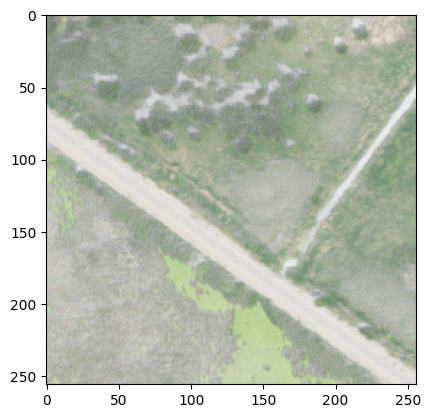

In [10]:
# plotting naip image
image = dataset[item[1]]["image"]
image = image.permute(1, 2, 0)

plt.imshow(image)
plt.show()

In [11]:
# creating a tuple out of the bounding box
item_bounds = (item[1].minx, item[1].miny, item[1].maxx, item[1].maxy)

(256, 256)


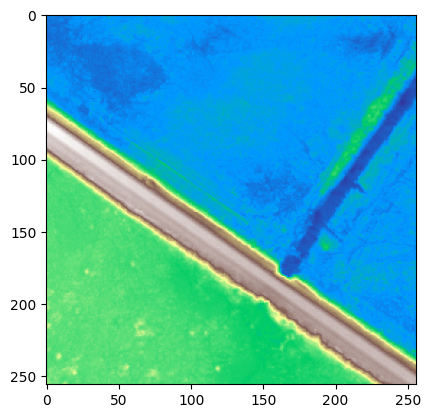

In [12]:
# converting DEM CRS to NAIP CRS and plotting the corresponding DEM image
with rasterio.open(str(config.KC_DEM_ROOT / Path("Kane2017BE.tif"))) as src:
    bbox = (item[1].minx, item[1].miny, item[1].maxx, item[1].maxy)
    bbox = rasterio.warp.transform_bounds(dataset.crs, src.crs, *bbox)
    window = src.window(*bbox)
    subset = src.read(1, window=window)
    print(subset.shape)
    show(subset, cmap="terrain")

In [13]:
# checking the CRS of the DEM object
dem.crs

CRS.from_epsg(26916)

In [14]:
# checking the output of the DEM object
dem[item[1]]["image"]

/home/mohitk/micromamba/envs/cmap/lib/python3.10/site-packages/rasterio/merge.py:321: UserWarning: Ignoring nodata value. The nodata value, -3.4028230607370965e+38, cannot safely be represented in the chosen data type, float32. Consider overriding it using the --nodata option for better results. Falling back to first source's nodata value.
  warnings.warn(


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])